In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
#     dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
#                                                                     labels=rates)) # 0-1
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
#     dlossA /= 2
#     dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
#     dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:0.6721 dlossA:0.6883 dlossQ:1.4931 exploreP:0.9985
Episode:1 meanR:19.0000 R:23.0000 rate:0.0460 gloss:0.6772 dlossA:0.6825 dlossQ:1.4949 exploreP:0.9962
Episode:2 meanR:24.0000 R:34.0000 rate:0.0680 gloss:0.6726 dlossA:0.6639 dlossQ:1.6046 exploreP:0.9929
Episode:3 meanR:22.5000 R:18.0000 rate:0.0360 gloss:0.6788 dlossA:0.6850 dlossQ:1.4993 exploreP:0.9911
Episode:4 meanR:24.6000 R:33.0000 rate:0.0660 gloss:0.6692 dlossA:0.6665 dlossQ:1.5888 exploreP:0.9879
Episode:5 meanR:24.5000 R:24.0000 rate:0.0480 gloss:0.6699 dlossA:0.6605 dlossQ:1.6273 exploreP:0.9856
Episode:6 meanR:23.8571 R:20.0000 rate:0.0400 gloss:0.6734 dlossA:0.6747 dlossQ:1.5659 exploreP:0.9836
Episode:7 meanR:22.2500 R:11.0000 rate:0.0220 gloss:0.6668 dlossA:0.6529 dlossQ:1.6630 exploreP:0.9825
Episode:8 meanR:21.3333 R:14.0000 rate:0.0280 gloss:0.6725 dlossA:0.6689 dlossQ:1.6204 exploreP:0.9812
Episode:9 meanR:21.4000 R:22.0000 rate:0.0440 gloss:0.6791 dlossA:0.6879 

Episode:79 meanR:26.8250 R:23.0000 rate:0.0460 gloss:0.6874 dlossA:0.6728 dlossQ:1.6729 exploreP:0.8088
Episode:80 meanR:26.9136 R:34.0000 rate:0.0680 gloss:0.6955 dlossA:0.6771 dlossQ:1.6856 exploreP:0.8061
Episode:81 meanR:26.7439 R:13.0000 rate:0.0260 gloss:0.6811 dlossA:0.6930 dlossQ:1.5679 exploreP:0.8050
Episode:82 meanR:26.5783 R:13.0000 rate:0.0260 gloss:0.7100 dlossA:0.6895 dlossQ:1.6529 exploreP:0.8040
Episode:83 meanR:26.6310 R:31.0000 rate:0.0620 gloss:0.6980 dlossA:0.6840 dlossQ:1.6385 exploreP:0.8016
Episode:84 meanR:26.9882 R:57.0000 rate:0.1140 gloss:0.6952 dlossA:0.6804 dlossQ:1.6610 exploreP:0.7971
Episode:85 meanR:26.7791 R:9.0000 rate:0.0180 gloss:0.7115 dlossA:0.6859 dlossQ:1.6464 exploreP:0.7964
Episode:86 meanR:26.6897 R:19.0000 rate:0.0380 gloss:0.7168 dlossA:0.6832 dlossQ:1.7159 exploreP:0.7949
Episode:87 meanR:27.0000 R:54.0000 rate:0.1080 gloss:0.6990 dlossA:0.6835 dlossQ:1.6594 exploreP:0.7906
Episode:88 meanR:26.9438 R:22.0000 rate:0.0440 gloss:0.6902 dloss

Episode:158 meanR:56.1300 R:46.0000 rate:0.0920 gloss:0.7578 dlossA:0.6942 dlossQ:1.7428 exploreP:0.4956
Episode:159 meanR:56.2300 R:64.0000 rate:0.1280 gloss:0.7721 dlossA:0.6948 dlossQ:1.7866 exploreP:0.4925
Episode:160 meanR:56.8100 R:117.0000 rate:0.2340 gloss:0.7719 dlossA:0.6993 dlossQ:1.7564 exploreP:0.4869
Episode:161 meanR:58.4800 R:181.0000 rate:0.3620 gloss:0.7629 dlossA:0.6947 dlossQ:1.7651 exploreP:0.4783
Episode:162 meanR:59.4300 R:121.0000 rate:0.2420 gloss:0.7752 dlossA:0.7064 dlossQ:1.7282 exploreP:0.4727
Episode:163 meanR:61.8000 R:248.0000 rate:0.4960 gloss:0.7807 dlossA:0.6928 dlossQ:1.8237 exploreP:0.4613
Episode:164 meanR:62.0000 R:55.0000 rate:0.1100 gloss:0.7729 dlossA:0.7030 dlossQ:1.7907 exploreP:0.4589
Episode:165 meanR:63.0800 R:144.0000 rate:0.2880 gloss:0.7750 dlossA:0.7057 dlossQ:1.7407 exploreP:0.4524
Episode:166 meanR:63.9000 R:132.0000 rate:0.2640 gloss:0.7728 dlossA:0.7009 dlossQ:1.7585 exploreP:0.4466
Episode:167 meanR:64.4800 R:74.0000 rate:0.1480 g

Episode:235 meanR:184.1900 R:150.0000 rate:0.3000 gloss:1.1400 dlossA:0.9670 dlossQ:1.0347 exploreP:0.1048
Episode:236 meanR:184.8500 R:174.0000 rate:0.3480 gloss:1.1596 dlossA:0.9407 dlossQ:1.0955 exploreP:0.1031
Episode:237 meanR:187.3000 R:259.0000 rate:0.5180 gloss:1.1862 dlossA:0.9982 dlossQ:1.1043 exploreP:0.1008
Episode:238 meanR:188.9900 R:190.0000 rate:0.3800 gloss:1.1844 dlossA:1.0247 dlossQ:1.0351 exploreP:0.0991
Episode:239 meanR:192.1100 R:328.0000 rate:0.6560 gloss:1.1840 dlossA:0.9806 dlossQ:1.0480 exploreP:0.0962
Episode:240 meanR:192.6800 R:198.0000 rate:0.3960 gloss:1.2317 dlossA:1.0375 dlossQ:1.1205 exploreP:0.0945
Episode:241 meanR:194.6100 R:337.0000 rate:0.6740 gloss:1.2360 dlossA:1.0451 dlossQ:1.1143 exploreP:0.0917
Episode:242 meanR:199.3800 R:500.0000 rate:1.0000 gloss:1.2515 dlossA:1.0452 dlossQ:1.1097 exploreP:0.0877
Episode:243 meanR:200.4800 R:192.0000 rate:0.3840 gloss:1.2676 dlossA:1.0758 dlossQ:1.0795 exploreP:0.0862
Episode:244 meanR:204.4000 R:420.0000

Episode:312 meanR:374.0900 R:500.0000 rate:1.0000 gloss:2.1138 dlossA:1.7317 dlossQ:0.3040 exploreP:0.0144
Episode:313 meanR:375.8900 R:500.0000 rate:1.0000 gloss:2.1201 dlossA:1.6396 dlossQ:0.2742 exploreP:0.0142
Episode:314 meanR:378.3700 R:500.0000 rate:1.0000 gloss:2.1151 dlossA:1.6270 dlossQ:0.2996 exploreP:0.0140
Episode:315 meanR:378.4900 R:358.0000 rate:0.7160 gloss:2.1579 dlossA:1.7152 dlossQ:0.2801 exploreP:0.0139
Episode:316 meanR:379.7300 R:500.0000 rate:1.0000 gloss:2.1398 dlossA:1.5611 dlossQ:0.2807 exploreP:0.0137
Episode:317 meanR:383.0300 R:500.0000 rate:1.0000 gloss:2.1884 dlossA:1.7430 dlossQ:0.3166 exploreP:0.0135
Episode:318 meanR:383.8500 R:295.0000 rate:0.5900 gloss:2.1795 dlossA:1.7487 dlossQ:0.3355 exploreP:0.0134
Episode:319 meanR:386.9100 R:500.0000 rate:1.0000 gloss:2.1701 dlossA:1.6038 dlossQ:0.3543 exploreP:0.0132
Episode:320 meanR:388.8200 R:500.0000 rate:1.0000 gloss:2.1928 dlossA:1.6425 dlossQ:0.3263 exploreP:0.0131
Episode:321 meanR:390.9200 R:500.0000

Episode:389 meanR:451.2600 R:500.0000 rate:1.0000 gloss:2.7855 dlossA:1.1057 dlossQ:0.6630 exploreP:0.0101
Episode:390 meanR:453.2100 R:500.0000 rate:1.0000 gloss:2.7537 dlossA:1.0894 dlossQ:0.6466 exploreP:0.0101
Episode:391 meanR:453.2100 R:500.0000 rate:1.0000 gloss:2.7516 dlossA:1.0626 dlossQ:0.7791 exploreP:0.0101
Episode:392 meanR:453.0500 R:274.0000 rate:0.5480 gloss:2.7386 dlossA:1.0045 dlossQ:0.6213 exploreP:0.0101
Episode:393 meanR:456.1000 R:500.0000 rate:1.0000 gloss:2.6892 dlossA:0.9894 dlossQ:0.7138 exploreP:0.0101
Episode:394 meanR:456.1000 R:500.0000 rate:1.0000 gloss:2.7437 dlossA:1.0746 dlossQ:0.8098 exploreP:0.0101
Episode:395 meanR:456.1000 R:500.0000 rate:1.0000 gloss:2.6665 dlossA:0.9832 dlossQ:0.8939 exploreP:0.0101
Episode:396 meanR:456.1000 R:500.0000 rate:1.0000 gloss:2.7089 dlossA:1.0035 dlossQ:0.7106 exploreP:0.0101
Episode:397 meanR:456.1000 R:500.0000 rate:1.0000 gloss:2.6372 dlossA:0.9003 dlossQ:0.6363 exploreP:0.0101
Episode:398 meanR:456.3000 R:385.0000

Episode:466 meanR:470.7800 R:500.0000 rate:1.0000 gloss:2.1251 dlossA:0.0216 dlossQ:0.4853 exploreP:0.0100
Episode:467 meanR:470.7800 R:500.0000 rate:1.0000 gloss:2.1101 dlossA:0.0196 dlossQ:0.5288 exploreP:0.0100
Episode:468 meanR:470.7800 R:500.0000 rate:1.0000 gloss:2.0920 dlossA:0.0151 dlossQ:0.5307 exploreP:0.0100
Episode:469 meanR:468.0900 R:231.0000 rate:0.4620 gloss:2.1225 dlossA:0.0085 dlossQ:0.5793 exploreP:0.0100
Episode:470 meanR:471.0800 R:500.0000 rate:1.0000 gloss:2.1190 dlossA:0.0101 dlossQ:0.5887 exploreP:0.0100
Episode:471 meanR:471.0800 R:500.0000 rate:1.0000 gloss:2.0670 dlossA:0.0081 dlossQ:0.6637 exploreP:0.0100
Episode:472 meanR:471.0800 R:500.0000 rate:1.0000 gloss:2.0950 dlossA:0.0124 dlossQ:0.7121 exploreP:0.0100
Episode:473 meanR:471.0800 R:500.0000 rate:1.0000 gloss:2.1307 dlossA:0.0123 dlossQ:0.7383 exploreP:0.0100
Episode:474 meanR:471.0800 R:500.0000 rate:1.0000 gloss:2.1249 dlossA:0.0170 dlossQ:0.8067 exploreP:0.0100
Episode:475 meanR:471.0800 R:500.0000

Episode:543 meanR:464.0600 R:500.0000 rate:1.0000 gloss:10.9045 dlossA:0.0000 dlossQ:298.4474 exploreP:0.0100
Episode:544 meanR:464.0600 R:500.0000 rate:1.0000 gloss:11.8923 dlossA:0.0000 dlossQ:344.8641 exploreP:0.0100
Episode:545 meanR:464.0600 R:500.0000 rate:1.0000 gloss:12.6867 dlossA:0.0000 dlossQ:385.9065 exploreP:0.0100
Episode:546 meanR:464.0600 R:500.0000 rate:1.0000 gloss:13.2080 dlossA:0.0000 dlossQ:442.1550 exploreP:0.0100
Episode:547 meanR:464.0600 R:500.0000 rate:1.0000 gloss:14.4195 dlossA:0.0000 dlossQ:489.8655 exploreP:0.0100
Episode:548 meanR:464.0600 R:500.0000 rate:1.0000 gloss:14.7228 dlossA:0.0000 dlossQ:535.6283 exploreP:0.0100
Episode:549 meanR:463.1700 R:411.0000 rate:0.8220 gloss:14.9429 dlossA:0.0000 dlossQ:578.1449 exploreP:0.0100
Episode:550 meanR:463.1700 R:500.0000 rate:1.0000 gloss:15.5167 dlossA:0.0000 dlossQ:614.0148 exploreP:0.0100
Episode:551 meanR:463.1700 R:500.0000 rate:1.0000 gloss:16.2936 dlossA:0.0000 dlossQ:644.1089 exploreP:0.0100
Episode:55

Episode:617 meanR:480.3400 R:500.0000 rate:1.0000 gloss:44.0420 dlossA:4.0309 dlossQ:16477.7754 exploreP:0.0100
Episode:618 meanR:480.3400 R:500.0000 rate:1.0000 gloss:45.1470 dlossA:3.9127 dlossQ:17814.4512 exploreP:0.0100
Episode:619 meanR:480.3400 R:500.0000 rate:1.0000 gloss:45.6259 dlossA:4.1319 dlossQ:18805.1445 exploreP:0.0100
Episode:620 meanR:480.3400 R:500.0000 rate:1.0000 gloss:46.5239 dlossA:6.0045 dlossQ:20463.8223 exploreP:0.0100
Episode:621 meanR:480.3400 R:500.0000 rate:1.0000 gloss:47.3399 dlossA:5.3829 dlossQ:21764.3242 exploreP:0.0100
Episode:622 meanR:480.3400 R:500.0000 rate:1.0000 gloss:47.7887 dlossA:4.4924 dlossQ:23235.3867 exploreP:0.0100
Episode:623 meanR:482.9100 R:500.0000 rate:1.0000 gloss:48.9539 dlossA:4.0655 dlossQ:25218.6152 exploreP:0.0100
Episode:624 meanR:484.1400 R:411.0000 rate:0.8220 gloss:50.9672 dlossA:4.5880 dlossQ:26735.2891 exploreP:0.0100
Episode:625 meanR:483.1600 R:402.0000 rate:0.8040 gloss:51.7061 dlossA:6.8171 dlossQ:28372.6016 exploreP

Episode:690 meanR:480.8000 R:309.0000 rate:0.6180 gloss:388.4120 dlossA:4.1048 dlossQ:2217877.5000 exploreP:0.0100
Episode:691 meanR:479.8100 R:401.0000 rate:0.8020 gloss:420.2983 dlossA:4.0264 dlossQ:2322579.7500 exploreP:0.0100
Episode:692 meanR:479.8100 R:500.0000 rate:1.0000 gloss:415.0001 dlossA:15.5097 dlossQ:2426302.2500 exploreP:0.0100
Episode:693 meanR:479.8100 R:500.0000 rate:1.0000 gloss:436.1271 dlossA:3.6507 dlossQ:2586661.5000 exploreP:0.0100
Episode:694 meanR:479.8100 R:500.0000 rate:1.0000 gloss:441.1065 dlossA:4.2498 dlossQ:2773272.0000 exploreP:0.0100
Episode:695 meanR:478.9700 R:416.0000 rate:0.8320 gloss:463.6521 dlossA:3.8957 dlossQ:2958821.0000 exploreP:0.0100
Episode:696 meanR:477.1700 R:320.0000 rate:0.6400 gloss:484.7496 dlossA:2.8586 dlossQ:3107686.7500 exploreP:0.0100
Episode:697 meanR:474.9400 R:277.0000 rate:0.5540 gloss:502.2662 dlossA:9.4725 dlossQ:3273549.7500 exploreP:0.0100
Episode:698 meanR:474.9400 R:500.0000 rate:1.0000 gloss:530.5032 dlossA:37.0157

Episode:761 meanR:471.9700 R:500.0000 rate:1.0000 gloss:3439.4326 dlossA:3.9382 dlossQ:74807456.0000 exploreP:0.0100
Episode:762 meanR:471.9700 R:500.0000 rate:1.0000 gloss:3624.0891 dlossA:4.4992 dlossQ:77789448.0000 exploreP:0.0100
Episode:763 meanR:471.9700 R:500.0000 rate:1.0000 gloss:3518.5107 dlossA:3.0422 dlossQ:80265536.0000 exploreP:0.0100
Episode:764 meanR:471.9700 R:500.0000 rate:1.0000 gloss:3679.9146 dlossA:2.6728 dlossQ:83967544.0000 exploreP:0.0100
Episode:765 meanR:471.9700 R:500.0000 rate:1.0000 gloss:3765.0784 dlossA:3.0396 dlossQ:87722280.0000 exploreP:0.0100
Episode:766 meanR:476.7400 R:500.0000 rate:1.0000 gloss:4027.3684 dlossA:3.5979 dlossQ:92011296.0000 exploreP:0.0100
Episode:767 meanR:475.0200 R:328.0000 rate:0.6560 gloss:3927.9946 dlossA:0.8864 dlossQ:94133408.0000 exploreP:0.0100
Episode:768 meanR:475.0200 R:500.0000 rate:1.0000 gloss:4157.1909 dlossA:2.8492 dlossQ:98715920.0000 exploreP:0.0100
Episode:769 meanR:475.0200 R:500.0000 rate:1.0000 gloss:4114.978

Episode:831 meanR:476.8500 R:500.0000 rate:1.0000 gloss:15030.0664 dlossA:2.0124 dlossQ:745240192.0000 exploreP:0.0100
Episode:832 meanR:476.8500 R:500.0000 rate:1.0000 gloss:15746.9102 dlossA:8.2367 dlossQ:761213632.0000 exploreP:0.0100
Episode:833 meanR:476.8500 R:500.0000 rate:1.0000 gloss:15649.2969 dlossA:9.0391 dlossQ:794929920.0000 exploreP:0.0100
Episode:834 meanR:476.8500 R:500.0000 rate:1.0000 gloss:16113.3311 dlossA:7.8540 dlossQ:816565952.0000 exploreP:0.0100
Episode:835 meanR:476.8500 R:500.0000 rate:1.0000 gloss:16141.0713 dlossA:152.2845 dlossQ:845415360.0000 exploreP:0.0100
Episode:836 meanR:476.8500 R:500.0000 rate:1.0000 gloss:16980.7500 dlossA:9.8482 dlossQ:863284288.0000 exploreP:0.0100
Episode:837 meanR:477.8300 R:500.0000 rate:1.0000 gloss:17023.3438 dlossA:8.3839 dlossQ:883059200.0000 exploreP:0.0100
Episode:838 meanR:476.2200 R:339.0000 rate:0.6780 gloss:17384.4043 dlossA:12.0375 dlossQ:906180160.0000 exploreP:0.0100
Episode:839 meanR:476.2200 R:500.0000 rate:1.

Episode:899 meanR:471.3000 R:500.0000 rate:1.0000 gloss:42920.4336 dlossA:107.3598 dlossQ:3775406848.0000 exploreP:0.0100
Episode:900 meanR:471.3000 R:500.0000 rate:1.0000 gloss:44535.5977 dlossA:111.8189 dlossQ:3833039616.0000 exploreP:0.0100
Episode:901 meanR:471.3000 R:500.0000 rate:1.0000 gloss:43762.9023 dlossA:82.2970 dlossQ:3984940032.0000 exploreP:0.0100
Episode:902 meanR:469.6800 R:338.0000 rate:0.6760 gloss:45845.3711 dlossA:44.2078 dlossQ:4037768448.0000 exploreP:0.0100
Episode:903 meanR:469.6800 R:500.0000 rate:1.0000 gloss:46905.1133 dlossA:55.1269 dlossQ:4129279232.0000 exploreP:0.0100
Episode:904 meanR:468.0900 R:341.0000 rate:0.6820 gloss:45940.5938 dlossA:90.0199 dlossQ:4191611136.0000 exploreP:0.0100
Episode:905 meanR:468.0900 R:500.0000 rate:1.0000 gloss:46612.6445 dlossA:77.8478 dlossQ:4257941760.0000 exploreP:0.0100
Episode:906 meanR:468.0900 R:500.0000 rate:1.0000 gloss:46973.2891 dlossA:105.9345 dlossQ:4385113600.0000 exploreP:0.0100
Episode:907 meanR:469.7900 R:

Episode:967 meanR:474.0900 R:500.0000 rate:1.0000 gloss:100788.0156 dlossA:96.7975 dlossQ:15882279936.0000 exploreP:0.0100
Episode:968 meanR:472.2300 R:314.0000 rate:0.6280 gloss:102488.2578 dlossA:81.3244 dlossQ:16259971072.0000 exploreP:0.0100
Episode:969 meanR:474.2200 R:500.0000 rate:1.0000 gloss:103842.2188 dlossA:75.1647 dlossQ:16642537472.0000 exploreP:0.0100
Episode:970 meanR:474.2200 R:500.0000 rate:1.0000 gloss:105246.5547 dlossA:157.5058 dlossQ:16795802624.0000 exploreP:0.0100
Episode:971 meanR:474.2200 R:500.0000 rate:1.0000 gloss:105021.4688 dlossA:132.4678 dlossQ:16937292800.0000 exploreP:0.0100
Episode:972 meanR:476.1300 R:500.0000 rate:1.0000 gloss:106659.8047 dlossA:144.3178 dlossQ:17214099456.0000 exploreP:0.0100
Episode:973 meanR:476.1900 R:500.0000 rate:1.0000 gloss:109427.2656 dlossA:215.4651 dlossQ:17815470080.0000 exploreP:0.0100
Episode:974 meanR:478.0200 R:500.0000 rate:1.0000 gloss:108613.3281 dlossA:96.0406 dlossQ:18040270848.0000 exploreP:0.0100
Episode:975 

Episode:1033 meanR:476.8100 R:500.0000 rate:1.0000 gloss:199556.1875 dlossA:387.5591 dlossQ:55349268480.0000 exploreP:0.0100
Episode:1034 meanR:476.8100 R:500.0000 rate:1.0000 gloss:208725.5938 dlossA:240.7156 dlossQ:57162121216.0000 exploreP:0.0100
Episode:1035 meanR:474.8400 R:303.0000 rate:0.6060 gloss:209070.0469 dlossA:245.0798 dlossQ:56501211136.0000 exploreP:0.0100
Episode:1036 meanR:474.8400 R:500.0000 rate:1.0000 gloss:208991.2656 dlossA:92.8281 dlossQ:59197341696.0000 exploreP:0.0100
Episode:1037 meanR:474.8400 R:500.0000 rate:1.0000 gloss:221212.9062 dlossA:147.7137 dlossQ:60995170304.0000 exploreP:0.0100
Episode:1038 meanR:474.8400 R:500.0000 rate:1.0000 gloss:213921.9375 dlossA:215.3325 dlossQ:62274097152.0000 exploreP:0.0100
Episode:1039 meanR:474.8400 R:500.0000 rate:1.0000 gloss:222418.2031 dlossA:334.3407 dlossQ:62901723136.0000 exploreP:0.0100
Episode:1040 meanR:473.0000 R:316.0000 rate:0.6320 gloss:220345.2188 dlossA:266.0411 dlossQ:63618187264.0000 exploreP:0.0100
E

Episode:1099 meanR:475.0700 R:500.0000 rate:1.0000 gloss:387018.3750 dlossA:0.0000 dlossQ:186788282368.0000 exploreP:0.0100
Episode:1100 meanR:475.0700 R:500.0000 rate:1.0000 gloss:399285.3125 dlossA:0.0000 dlossQ:193029554176.0000 exploreP:0.0100
Episode:1101 meanR:475.0700 R:500.0000 rate:1.0000 gloss:396391.8125 dlossA:0.0000 dlossQ:188827729920.0000 exploreP:0.0100
Episode:1102 meanR:475.0700 R:500.0000 rate:1.0000 gloss:400891.9688 dlossA:0.0000 dlossQ:188800024576.0000 exploreP:0.0100
Episode:1103 meanR:475.0700 R:500.0000 rate:1.0000 gloss:413181.5000 dlossA:0.0000 dlossQ:201701490688.0000 exploreP:0.0100
Episode:1104 meanR:475.0700 R:500.0000 rate:1.0000 gloss:413880.0000 dlossA:0.0000 dlossQ:204809142272.0000 exploreP:0.0100
Episode:1105 meanR:475.0700 R:500.0000 rate:1.0000 gloss:418904.1250 dlossA:0.0000 dlossQ:207319793664.0000 exploreP:0.0100
Episode:1106 meanR:475.0700 R:500.0000 rate:1.0000 gloss:419936.7812 dlossA:0.0000 dlossQ:209163927552.0000 exploreP:0.0100
Episode:

Episode:1166 meanR:485.4700 R:500.0000 rate:1.0000 gloss:683692.6250 dlossA:0.0000 dlossQ:523352244224.0000 exploreP:0.0100
Episode:1167 meanR:485.4700 R:500.0000 rate:1.0000 gloss:683084.3125 dlossA:0.0000 dlossQ:529997692928.0000 exploreP:0.0100
Episode:1168 meanR:485.4700 R:500.0000 rate:1.0000 gloss:708335.7500 dlossA:0.0000 dlossQ:549530796032.0000 exploreP:0.0100
Episode:1169 meanR:485.4700 R:500.0000 rate:1.0000 gloss:703866.0000 dlossA:0.0000 dlossQ:547164061696.0000 exploreP:0.0100
Episode:1170 meanR:485.4700 R:500.0000 rate:1.0000 gloss:698469.4375 dlossA:0.0000 dlossQ:550359138304.0000 exploreP:0.0100
Episode:1171 meanR:485.4700 R:500.0000 rate:1.0000 gloss:738225.1250 dlossA:0.0000 dlossQ:559046852608.0000 exploreP:0.0100
Episode:1172 meanR:485.4700 R:500.0000 rate:1.0000 gloss:690385.0000 dlossA:0.0000 dlossQ:557425098752.0000 exploreP:0.0100
Episode:1173 meanR:486.8200 R:500.0000 rate:1.0000 gloss:720360.5625 dlossA:0.0000 dlossQ:579874717696.0000 exploreP:0.0100
Episode:

Episode:1233 meanR:480.7300 R:500.0000 rate:1.0000 gloss:942114.1250 dlossA:2.7687 dlossQ:885765177344.0000 exploreP:0.0100
Episode:1234 meanR:480.7300 R:500.0000 rate:1.0000 gloss:931595.5000 dlossA:5.6390 dlossQ:906560602112.0000 exploreP:0.0100
Episode:1235 meanR:480.7300 R:500.0000 rate:1.0000 gloss:950100.1250 dlossA:13.4556 dlossQ:851842564096.0000 exploreP:0.0100
Episode:1236 meanR:480.7300 R:500.0000 rate:1.0000 gloss:944122.1250 dlossA:6.5010 dlossQ:917883518976.0000 exploreP:0.0100
Episode:1237 meanR:480.7300 R:500.0000 rate:1.0000 gloss:942341.1250 dlossA:3.5817 dlossQ:914707709952.0000 exploreP:0.0100
Episode:1238 meanR:480.7300 R:500.0000 rate:1.0000 gloss:929330.4375 dlossA:10.6206 dlossQ:900376690688.0000 exploreP:0.0100
Episode:1239 meanR:480.7300 R:500.0000 rate:1.0000 gloss:970046.7500 dlossA:13.2381 dlossQ:886836690944.0000 exploreP:0.0100
Episode:1240 meanR:480.7300 R:500.0000 rate:1.0000 gloss:968567.8750 dlossA:11.9508 dlossQ:947887276032.0000 exploreP:0.0100
Epis

Episode:1298 meanR:483.6500 R:500.0000 rate:1.0000 gloss:1086525.2500 dlossA:58.9578 dlossQ:1210040451072.0000 exploreP:0.0100
Episode:1299 meanR:483.6500 R:500.0000 rate:1.0000 gloss:1111623.0000 dlossA:49.7128 dlossQ:1230584152064.0000 exploreP:0.0100
Episode:1300 meanR:482.0000 R:335.0000 rate:0.6700 gloss:1147481.3750 dlossA:0.0000 dlossQ:1236828422144.0000 exploreP:0.0100
Episode:1301 meanR:482.0000 R:500.0000 rate:1.0000 gloss:1141755.7500 dlossA:45.9335 dlossQ:1236321697792.0000 exploreP:0.0100
Episode:1302 meanR:482.0000 R:500.0000 rate:1.0000 gloss:1134430.6250 dlossA:0.0000 dlossQ:1303596367872.0000 exploreP:0.0100
Episode:1303 meanR:482.0000 R:500.0000 rate:1.0000 gloss:1129609.2500 dlossA:69.6595 dlossQ:1210734870528.0000 exploreP:0.0100
Episode:1304 meanR:482.0000 R:500.0000 rate:1.0000 gloss:1151239.8750 dlossA:56.8018 dlossQ:1251629465600.0000 exploreP:0.0100
Episode:1305 meanR:482.0000 R:500.0000 rate:1.0000 gloss:1147903.5000 dlossA:19.2783 dlossQ:1250139308032.0000 ex

Episode:1362 meanR:489.4100 R:500.0000 rate:1.0000 gloss:1225423.7500 dlossA:2982.1641 dlossQ:1398855303168.0000 exploreP:0.0100
Episode:1363 meanR:489.4100 R:500.0000 rate:1.0000 gloss:1230816.0000 dlossA:14030.4805 dlossQ:1533022306304.0000 exploreP:0.0100
Episode:1364 meanR:489.4100 R:500.0000 rate:1.0000 gloss:1278061.8750 dlossA:8450.4971 dlossQ:1475075112960.0000 exploreP:0.0100
Episode:1365 meanR:491.0400 R:500.0000 rate:1.0000 gloss:1217331.0000 dlossA:8913.8496 dlossQ:1480662712320.0000 exploreP:0.0100
Episode:1366 meanR:492.0000 R:500.0000 rate:1.0000 gloss:1249827.5000 dlossA:6510.3052 dlossQ:1476239294464.0000 exploreP:0.0100
Episode:1367 meanR:492.0000 R:500.0000 rate:1.0000 gloss:1200783.1250 dlossA:7088.2939 dlossQ:1495010508800.0000 exploreP:0.0100
Episode:1368 meanR:492.0000 R:500.0000 rate:1.0000 gloss:1256020.1250 dlossA:8703.1963 dlossQ:1491920748544.0000 exploreP:0.0100
Episode:1369 meanR:491.8500 R:373.0000 rate:0.7460 gloss:1271892.7500 dlossA:5448.7861 dlossQ:14

Episode:1426 meanR:489.7100 R:500.0000 rate:1.0000 gloss:1253544.7500 dlossA:55569.8398 dlossQ:1614516846592.0000 exploreP:0.0100
Episode:1427 meanR:489.7100 R:500.0000 rate:1.0000 gloss:1255910.8750 dlossA:44600.0781 dlossQ:1668582342656.0000 exploreP:0.0100
Episode:1428 meanR:488.8300 R:412.0000 rate:0.8240 gloss:1277707.6250 dlossA:48104.6445 dlossQ:1624821858304.0000 exploreP:0.0100
Episode:1429 meanR:487.6400 R:381.0000 rate:0.7620 gloss:1235766.6250 dlossA:47729.8984 dlossQ:1625813286912.0000 exploreP:0.0100
Episode:1430 meanR:487.1200 R:448.0000 rate:0.8960 gloss:1285700.2500 dlossA:135071.7656 dlossQ:1669338628096.0000 exploreP:0.0100
Episode:1431 meanR:487.1200 R:500.0000 rate:1.0000 gloss:1258124.5000 dlossA:93499.2500 dlossQ:1714920357888.0000 exploreP:0.0100
Episode:1432 meanR:487.1200 R:500.0000 rate:1.0000 gloss:1193585.8750 dlossA:80849.2109 dlossQ:1692300738560.0000 exploreP:0.0100
Episode:1433 meanR:487.1200 R:500.0000 rate:1.0000 gloss:1233537.0000 dlossA:49290.3984 d

Episode:1489 meanR:487.6900 R:500.0000 rate:1.0000 gloss:1112277.0000 dlossA:115445.3594 dlossQ:1708925124608.0000 exploreP:0.0100
Episode:1490 meanR:487.6900 R:500.0000 rate:1.0000 gloss:1125786.1250 dlossA:79238.5391 dlossQ:1475144843264.0000 exploreP:0.0100
Episode:1491 meanR:487.6900 R:500.0000 rate:1.0000 gloss:1119434.3750 dlossA:94955.2812 dlossQ:1456120659968.0000 exploreP:0.0100
Episode:1492 meanR:488.9600 R:500.0000 rate:1.0000 gloss:1117845.2500 dlossA:78097.0547 dlossQ:1547202330624.0000 exploreP:0.0100
Episode:1493 meanR:488.9600 R:500.0000 rate:1.0000 gloss:1114979.3750 dlossA:86720.9922 dlossQ:1618379669504.0000 exploreP:0.0100
Episode:1494 meanR:488.0800 R:412.0000 rate:0.8240 gloss:1098061.8750 dlossA:49651.5781 dlossQ:1429805465600.0000 exploreP:0.0100
Episode:1495 meanR:489.1300 R:500.0000 rate:1.0000 gloss:1117492.2500 dlossA:89416.5781 dlossQ:1484088541184.0000 exploreP:0.0100
Episode:1496 meanR:488.5700 R:444.0000 rate:0.8880 gloss:1134171.5000 dlossA:65889.0156 d

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

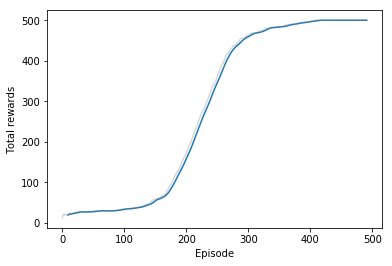

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

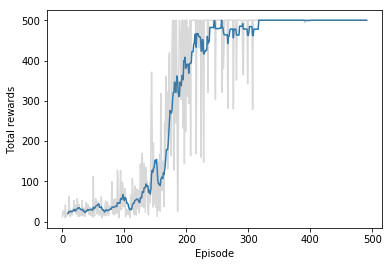

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.